# Task 1

## Reconstruct H2 wave function from projective measurement results

- Simply train RBM for respective $r$'s
- Draw data points calculated by sampled configurations over ground truth energy curve

## Training

In [ ]:

import csv
import re
from glob import glob
from pathlib import Path

import numpy as np
import torch

import H2_energy_calculator
from RBM_helper import RBM
n_vis = 2
n_hin = 10
epochs = 1000 # number of training steps
num_samples = 2000 # number of samples to generate from the RBM to calculate the H2 energy

coeffs = np.loadtxt("H2_data/H2_coefficients.txt")

log_dir = Path("training_logs")
logs = { }
samples = [sample_file for sample_file in glob('H2_data/*_samples.txt')]

for sample_file in glob('H2_data/*_samples.txt'):
    print(sample_file)
    match = re.match(r".*R_([0-9.]+)_samples.txt", sample_file)
    r = match.groups(0)[0]
    coeff_idx = np.where(coeffs[:,0].astype(np.float) == float(r))[0][0]
    coeff = coeffs[coeff_idx,:]

    psi_file = f"H2_data/R_{r}_psi.txt"
    psi = np.loadtxt(psi_file)
    training_data = torch.from_numpy(np.loadtxt(sample_file))

    rbm = RBM(n_vis, n_hin)

    true_energy = H2_energy_calculator.energy_from_freq(training_data, coeff)
    print(f"H2 energy for r = {r}: ",true_energy)
    logs[f"r_{r}_energy_diff"] = []
    logs[f"r_{r}_fidelity"] = []
    save_dir = f'params/trained_r_{r}'
    for e in range(1, epochs+1):
        # do one epoch of training
        rbm.train(training_data)

        # now generate samples and calculate the energy
        if e % 1 == 0:
            print("Epoch: ", e)
            # For sampling the RBM, we need to do Gibbs sampling.
            # Initialize the Gibbs sampling chain with init_state as defined below.
            init_state = torch.zeros(num_samples, n_vis)
            RBM_samples = rbm.draw_samples(15, init_state)
            energies = H2_energy_calculator.energy(RBM_samples, coeff, rbm.wavefunction)
            energy = energies.item()
            print("Energy from RBM samples: ", energies.item())

            energy_difference = abs(true_energy - energy)
            print("Energy difference from RBM samples: ", energy_difference)
            logs[f"r_{r}_energy_diff"].append(energy_difference)

            rbm_psi = rbm.psi()
            overlap = np.abs(np.vdot(psi, rbm_psi))
            print("Fidelity from RBM samples: ", overlap)
            logs[f"r_{r}_fidelity"].append(overlap)

            print("Log likelihood: ", rbm.log_likelihood(training_data))
            print()

In [ ]:
with open(log_dir / f"task1_log.csv", 'w') as f:
    w = csv.DictWriter(f, logs.keys())
    w.writeheader()
    w.writerow(logs)

## Results

- The result seems good.
- Larger error on higher energy, it will be a strong quantum correlation effect.

MSE: 0.0012142969404975426 [ev]


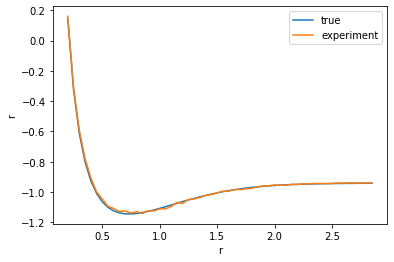

In [8]:
import pandas as pd
import numpy as np

df = pd.read_csv('training_logs/task1-r-E.csv', index_col=0).sort_index()
ax = df.plot()
ax.set_ylabel('Energy [eV]')
ax.set_ylabel('r')

std = np.sqrt(np.sum((df['true'] - df['experiment'])**2))/len(df)
print(f"MSE: {std} [ev]")


Text(0, 0.5, '|ΔE| [eV]')

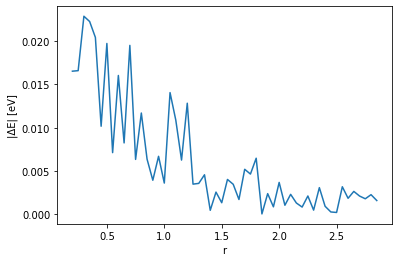

In [7]:
diff_df = (df['true'] - df['experiment']).abs()
ax = diff_df.plot()
ax.set_ylabel('|ΔE| [eV]')

Text(0, 0.5, '|ΔE|/|E|')

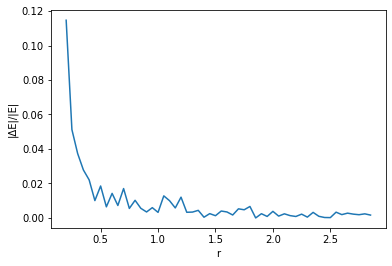

In [15]:
diff_ratio_df = diff_df / df['true'].abs()

ax = diff_ratio_df.plot()
ax.set_ylabel('|ΔE|/|E|')
